In [2]:
import os                                                                      # handles files using system commands
import pickle                                                                  # stores the features extracted                 
import numpy as np                                                             # performs math on arrays
from tqdm.notebook import tqdm                                                 # progress bar decorator for iterators

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input       # VGG16 for feature extraction from an image
from tensorflow.keras.preprocessing.image import load_img , img_to_array       # loading image and converting it to a numpy array
from tensorflow.keras.preprocessing.text import Tokenizer                      # tokenizing the text
from tensorflow.keras.preprocessing.sequence import pad_sequences              # padding for equal size distribution
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [3]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

we have loaded the VGG16 model for feature extraction of an image.VGG16 is pretrained on Imagenet datbase and classifies objects into 1000 diferent calsses

In [4]:
model = VGG16()                                                               # loading thr pre-trained model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)      # restructing the model
print(model.summary())                                                        # printing the model summary

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


Now we will do the feature extraction and preprocessing the data

In [5]:
features = {}                                                                     # extract features from image
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name                                         # loading the image from file
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)                                                   # converting image pixels to numpy array
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))    # reshaping data 
    image = preprocess_input(image)                                               # preprocessing the image for vgg16
    feature = model.predict(image, verbose=0)                                     # extracting features from an image
    image_id = img_name.split('.')[0]                                             # get the image ID
    features[image_id] = feature                                                  # storing the extracted features

  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
print("Number of extracted features:", len(features)) 

# Printing the shape of one extracted feature
sample_key = list(features.keys())[0]
print("Sample Image ID:", sample_key)
print("Extracted Feature Shape:", features[sample_key].shape)  


Number of extracted features: 8091
Sample Image ID: 3226254560_2f8ac147ea
Extracted Feature Shape: (1, 4096)


In [7]:
features[image_id] = feature.flatten()                                            # Convert (1, 4096) → (4096,)


In [8]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))      # storing the features using pickle

In [9]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:                  # loading the features for quick acess 
    features = pickle.load(f)

In [10]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:                     # loading the captions
    next(f)
    captions_doc = f.read()

In [11]:
mapping = {}                                                                     # mapping of image to captions
for line in tqdm(captions_doc.split('\n')):                                      # processing lines
    tokens = line.split(',')                                                     # splitting the line by comma
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]                                            # removing the extension from image ID
    caption = " ".join(caption)                                                  # converting caption list to string
    if image_id not in mapping:                                                  # creating list if needed
        mapping[image_id] = []
    mapping[image_id].append(caption)                                            # storing the caption

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(mapping)                                                                     # checking number of images loaded

8091

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]                                              # taking one caption at a time
            caption = caption.lower()                                          # converting text to lowercase 
            caption = caption.replace('[^A-Za-z]', '')                         # deleting digits, special chars, etc.,
            caption = caption.replace('\s+', ' ')                              # deleting space
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'  # adding start and end tags to the caption
            captions[i] = caption

In [14]:
mapping['1000268201_693b08cb0e']                                              # text before preprocessing

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [15]:
clean(mapping)                                                               # now preprocessing the text

In [16]:
mapping['1000268201_693b08cb0e']                                             # text after preprocessing

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [17]:
all_captions = []                                                          # storing all the captions to the list
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [18]:
len(all_captions)                                                         # checking the number of unique captions

40455

In [19]:
all_captions[:15]                                                         # checking the 15 captions

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas 

In [20]:
tokenizer = Tokenizer()                                               # tokenizing the text
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
vocab_size                                                            # checking the vocab size which shows num of unique words

8485

In [22]:
max_length = max(len(caption.split()) for caption in all_captions)  # getting the max length of caption so used for padding
max_length

35

In [24]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)                                  # tarin test split of 90/10
train = image_ids[:split]
test = image_ids[split:]

In [71]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:                                                     # Processing each caption
                seq = tokenizer.texts_to_sequences([caption])[0]                         # Encoding the sequence
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]                                    # Splitting into input and output pairs
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]               # Padding the input sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]       # Encoding the output sequence
                    X1.append(features[key].reshape(-1))  # Ensure correct shape (4096,)  # Storing the the sequences
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
                yield (np.array(X1), np.array(X2)), np.array(y)

                X1, X2, y = list(), list(), list()
                n = 0


In [72]:
gen = data_generator(train_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size)
batch = next(gen)  # Retrieve one batch

X1, X2 = batch[0]
y = batch[1]

print("Feature vector shape:", X1.shape) 
print("Caption sequence shape:", X2.shape)  
print("Target shape:", y.shape)  


Feature vector shape: (1635, 4096)
Caption sequence shape: (1635, 35)
Target shape: (1635, 8485)


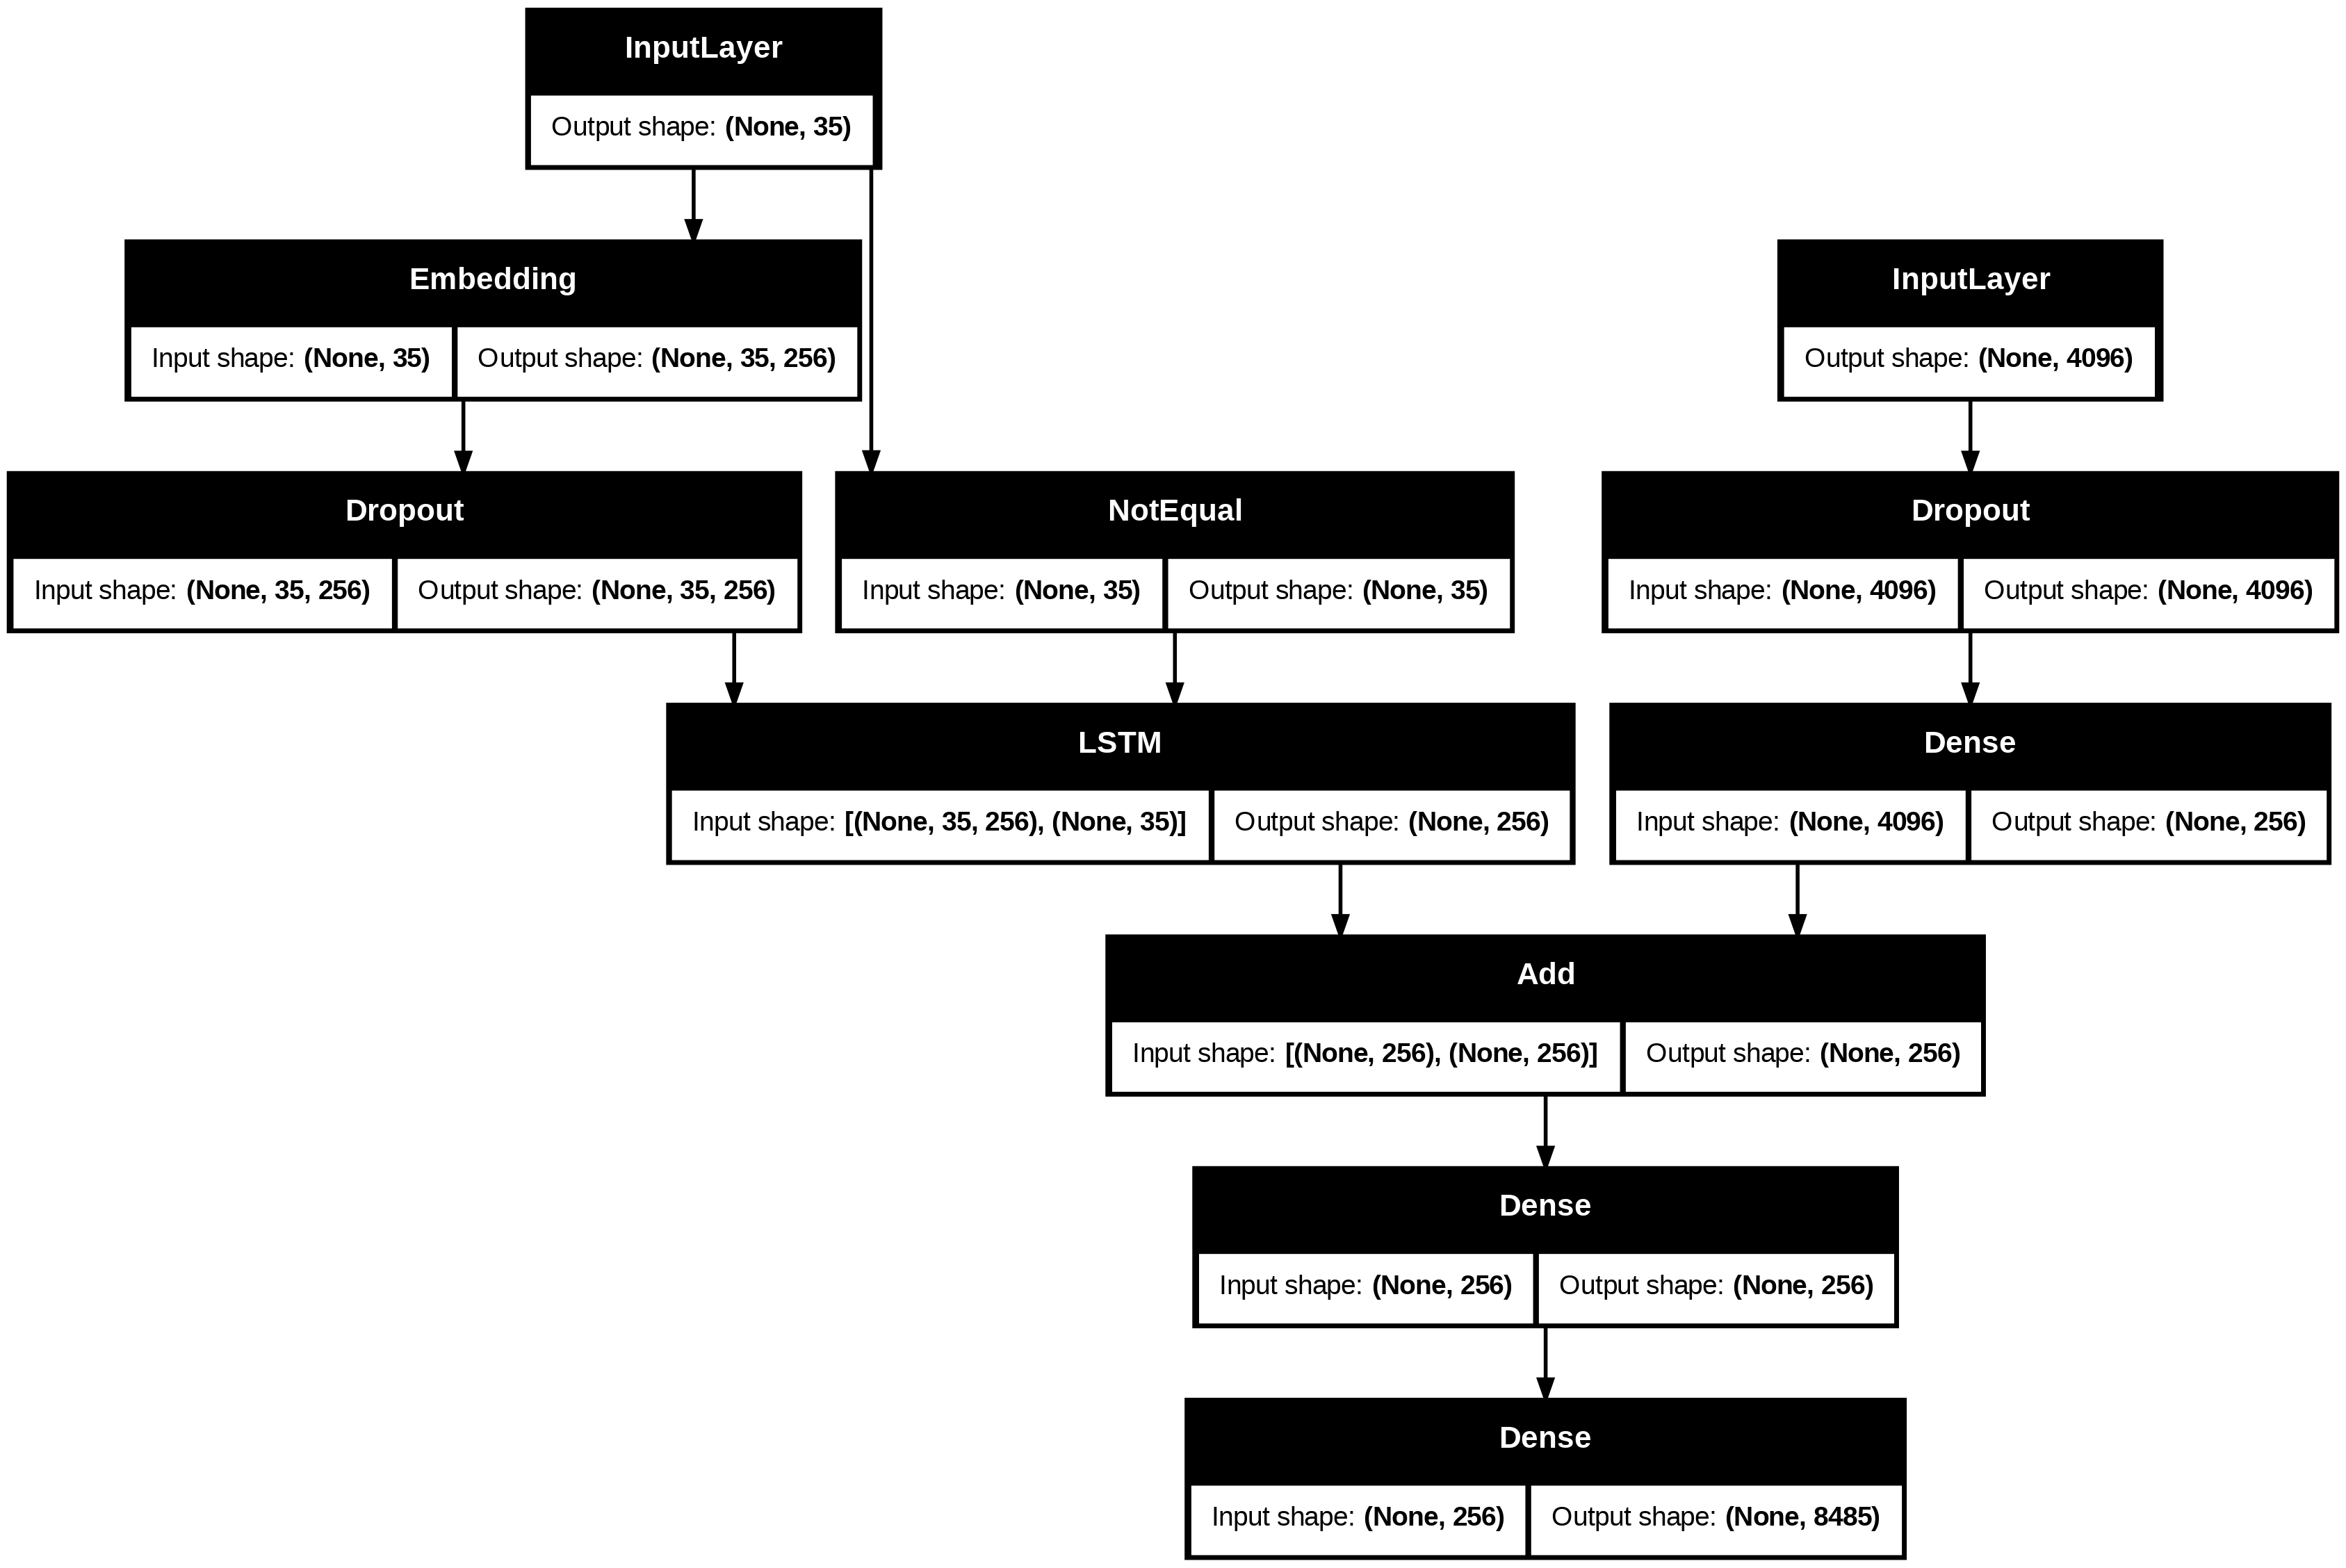

In [41]:
# encoder model

# image feature layers
inputs1 = Input(shape=(4096,))                                     # output length of the features from the VGG model
fe1 = Dropout(0.4)(inputs1)                                        # dropout rate of 40 to add regularization to the data,
fe2 = Dense(256, activation='relu')(fe1)                           #  single dimension linear layer array with relu as activation
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, return_sequences=False, recurrent_activation='sigmoid', unroll=False, use_cudnn=False)(se2)


# decoder model

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)       # softmax in output layer

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')  # categorical_crossentropy as loss func and adams as optimizer

plot_model(model, show_shapes=True)                               # plotting the model

In [45]:
epochs = 25
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - loss: 4.6437
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 271ms/step - loss: 3.7962
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 271ms/step - loss: 3.4452
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 273ms/step - loss: 3.2088
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 271ms/step - loss: 3.0260
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 273ms/step - loss: 2.8857
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.7747
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 275ms/step - loss: 2.6824
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 271ms/step - loss: 2.6098
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 271ms/step - loss: 2.5434
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 273ms/step - loss: 2.4786
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 270ms/step - loss: 2.4262
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 269ms/step - loss: 2.3709
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 273ms/step - loss: 2.3233
227/227 ━━━━━━━━━━━━━━━━━━━━ 63s 277ms/step - loss: 2.2886
227/227 ━━━━━━━━━━━━━━━━━━━━ 63s 278ms/step - loss: 2.2481
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 273ms/step - loss: 2.2144

In [46]:
model.save(WORKING_DIR+'/best_model.h5')                           # saving the model

In [47]:
def idx_to_word(integer, tokenizer):                               # converting the model output integer to word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [65]:
# generating caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = ' start: '                                           # adding start tag for generation process
    for i in range(max_length):                                    # iterate over the max length of sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]      # encoding input sequence
        sequence = pad_sequences([sequence], max_length)           # padding the sequence
        yhat = model.predict([image, sequence], verbose=0)         # predicting next word
        yhat = np.argmax(yhat)                                     # get index with high probability
        word = idx_to_word(yhat, tokenizer)                        # converting index to word
        if word is None:                                           # stop if word not found
            break
        in_text += " " + word                                      # appendding word as input for generating next word
        if word == 'endseq':                                       # stopping if we reach end tag
            break
    return in_text

In [49]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()                                             # validating with test data

for key in tqdm(test):
    captions = mapping[key]                                                    # get actual caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length)      # predicting the caption for image
    actual_captions = [caption.split() for caption in captions]                # splitting into words
    y_pred = y_pred.split()
    actual.append(actual_captions)                                             # appendding to the list
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.540278
BLEU-2: 0.309408


In [50]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('Actual Caption...................')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('Model Generated Captions.............')
    print(y_pred)
    plt.imshow(image)

Actual Caption...................
startseq "a dog shakes its head near the shore red ball next to it ." endseq
startseq white dog shakes on the edge of beach with an orange ball endseq
startseq "dog with orange ball at feet stands on shore shaking off water" endseq
startseq white dog playing with red ball on the shore near the water endseq
startseq white dog with brown ears standing near water with head turned to one side endseq
Model Generated Captions.............
 start:  with yellow toy in the water endseq is wearing red harness endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


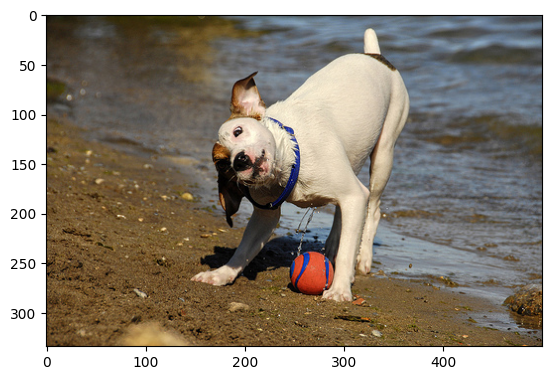

In [73]:
generate_caption("1012212859_01547e3f17.jpg")

Actual Caption...................
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
Model Generated Captions.............
startseq man in green shirt and sunglasses is walking in front of skyscraper endseq


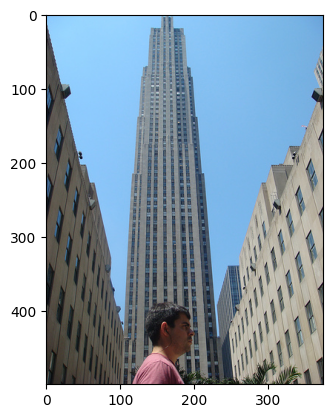

In [57]:
generate_caption("1032460886_4a598ed535.jpg")